In [11]:
import pandas as pd
from datetime import timedelta
import scipy.stats
import numpy as np

# read .swd file into dataframe
df1 = pd.read_csv('310816.swd', header = None)

# split string into columns based on the file specs
df1['Household'] = df1[0].apply(lambda x: x[0:8])
df1['Individual'] = df1[0].apply(lambda x: x[8:10])
df1['Channel'] = df1[0].apply(lambda x: x[10:14])
df1['Channel'] = df1['Channel'].astype(int)
df1['Start time'] = df1[0].apply(lambda x: x[14:20])
df1['End time'] = df1[0].apply(lambda x: x[20:26])
df1['TV set'] = df1[0].apply(lambda x: x[26])
df1['Audience Type'] = df1[0].apply(lambda x: x[27])

# make Household, Individual multiindex
df1 = df1.set_index(['Household','Individual'])
df1 = df1.sort_index()

# create column for total time in each session
df1['Start time'] = df1['Start time'].apply(lambda x: timedelta(hours=int(x[0:2])-2, minutes=int(x[2:4]), seconds=int(x[4:])))
df1['End time'] = df1['End time'].apply(lambda x: timedelta(hours=int(x[0:2])-2, minutes=int(x[2:4]), seconds=int(x[4:])))
df1['Session time'] = df1['End time'] - df1['Start time']

# include channel genre
channels = pd.read_excel("channel - genre map.xlsx")#.groupby(level=0).apply(lambda x: dict(x.to_records(False))).to_dict()
channel_dict = dict(zip(channels['CHANNEL CODE'], channels['CHANNEL GENRE']))
df1['Channel Genre'] = df1['Channel'].apply(lambda x: channel_dict[x])
df1['Channel'] = df1['Channel'].astype(int)#.astype(str)

#fix typo
df1['Channel Genre'] = df1['Channel Genre'].str.replace("Entertaiment","Entertainment")

# map channel names according to channel_dict
channel_dict = {}
channels = np.sort(df1['Channel'].unique())
for i in range(len(channels)):
    channel_dict[channels[i]] = i
df1['Channel'] = df1['Channel'].apply(lambda x: channel_dict[x])

# read .dem file into data frame
df2 = pd.read_csv('310816.dem', header = None, encoding = "latin_1")

# split string into columns based on the file specs
df2['Household'] = df2[0].apply(lambda x: x[0:8])
df2['Individual'] = df2[0].apply(lambda x: x[8:10])
df2['Weight'] = df2[0].apply(lambda x: x[10:18])
df2['Weight'] = df2['Weight'].astype(float)
df2['Viewer Type'] = df2[0].apply(lambda x: x[18])
df2['Sample Type'] = df2[0].apply(lambda x: x[19])
df2['Sex'] = df2[0].apply(lambda x: x[20])
df2['Age'] = df2[0].apply(lambda x: ord(x[21])-48)
df2['Age Category'] = df2[0].apply(lambda x: x[22])
df2['Education Level'] = df2[0].apply(lambda x: x[23])
df2['Occupation Categories'] = df2[0].apply(lambda x: x[24])
df2['Personal Income'] = df2[0].apply(lambda x: ord(x[25])-48)
df2['Average Household Income'] = df2[0].apply(lambda x: ord(x[26])-48)
df2['Household size'] = df2[0].apply(lambda x: x[27])
df2['Children in household (4-9)'] = df2[0].apply(lambda x: x[28])
df2['Children in household (10-14)'] = df2[0].apply(lambda x: x[29])
df2['Grocery purch. decision maker'] = df2[0].apply(lambda x: x[30])
df2['Any pet'] = df2[0].apply(lambda x: x[31])
df2['VCR'] = df2[0].apply(lambda x: x[32])
df2['Number of TV sets in HH'] = df2[0].apply(lambda x: x[33])
df2['Area'] = df2[0].apply(lambda x: x[34])
df2['Standard of living index (Canceled)'] = df2[0].apply(lambda x: x[35])
df2['Can receive any cable TV'] = df2[0].apply(lambda x: x[36])
df2['Can receive any satellite TV'] = df2[0].apply(lambda x: x[37])
df2['Receiver Type'] = df2[0].apply(lambda x: x[38])
df2['Can receive any Star TV CH.'] = df2[0].apply(lambda x: x[39])
df2['Can receive any CETV'] = df2[0].apply(lambda x: x[40])
df2['Marital Status'] = df2[0].apply(lambda x: x[41])
df2['Occupation Categories (2006)'] = df2[0].apply(lambda x: x[42])

# make Household, Individual multiindex
df2 = df2.set_index(['Household','Individual'])
df2 = df2.sort_index()

# delete original string columns
del df2[0]
del df1[0]

#df2.head()
df1.head()


Channel Start time End time TV set Audience Type  \
Household Individual                                                     
26405151  01                0   10:41:00 11:04:59      9             1   
          01                0   18:14:00 19:52:59      9             1   
          01               24   06:20:00 06:43:59      9             1   
          01               24   08:37:00 08:37:59      9             1   
          01               32   06:18:00 06:19:59      9             1   

                     Session time Channel Genre  
Household Individual                             
26405151  01             00:23:59       General  
          01             01:38:59       General  
          01             00:23:59       General  
          01             00:00:59       General  
          01             00:01:59       General

In [10]:
# create new series by aggregating values for each individual
sessions = df1.groupby(level=[0,1])['Channel'].agg(lambda x: len(x)) # number of sessions per individual
time = df1.groupby(level=[0,1])['Session time'].sum(axis=1) # total time per individual
tv = df1.groupby(level=[0,1])['TV set'].agg(lambda x: scipy.stats.mode(x)[0][0]) # most frequent TV set for each individual
chan = df1.groupby(level=[0,1])['Channel'].agg(lambda x: scipy.stats.mode(x)[0][0]) # most frequent channel for each individual
aud = df1.groupby(level=[0,1])['Audience Type'].agg(lambda x: scipy.stats.mode(x)[0][0]) # most frequent audience type for each individual
genre = df1.groupby(level=[0,1])['Channel Genre'].agg(lambda x: scipy.stats.mode(x)[0][0])  # most frequent channel genre for each individual

# add the new series to df2 dataframe
df_final = df2.copy()
df_final['No. of sessions'] = sessions
df_final['Total time'] = time
df_final['Most freq TV'] = tv
df_final['Most freq channel'] = chan
df_final['Most freq audience type'] = aud
df_final['Most freq genre'] = genre#.astype('category')
df_final = df_final.dropna()
df_final['Most freq genre'] = df_final['Most freq genre']

# label 'General' genre as 1, and niche genres (movies, sports, etc.) as 2
mapping = {'General': 1, 'Education': 2, 'Music':3, 'Entertainment':4, 'News':5, 'Children':6, 'Movie':7, 'Lifestyle':8, 'Society':9, 'Sports':10, 'Finance':11, 'Documentary':12}
#mapping = {'General': 1, 'Education': 2, 'Music':2, 'Entertainment':2, 'News':2, 'Children':2, 'Movie':2, 'Lifestyle':2, 'Society':2, 'Sports':2, 'Finance':2, 'Documentary':2}
df_final['Most freq genre'] = df_final['Most freq genre'].apply(lambda x: mapping[x])

# output to csv file
#df_final.to_csv('output.csv')

df_final.head()

/home/rob/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Weight Viewer Type Sample Type Sex  Age Age Category  \
Household Individual                                                          
26405151  01           5.5611           1           1   2   68            7   
          02           6.2414           1           1   1   68            7   
26405338  02           5.5611           1           1   2   61            6   
          03          18.6235           1           1   1   29            3   
26405431  01           5.5611           1           1   2   68            7   

                     Education Level Occupation Categories  Personal Income  \
Household Individual                                                          
26405151  01                       4                     5               12   
          02                       4                     5               12   
26405338  02                       3                     5                7   
          03                       5                     4                7   
26405431  01                       5                     5               13   

                      Average Household Income       ...        \
Household Individual                                 ...         
26405151  01                                21       ...         
          02                                21       ...         
26405338  02                                14       ...         
          03                                14       ...         
26405431  01                                21       ...         

                     Can receive any Star TV CH. Can receive any CETV  \
Household Individual                                                    
26405151  01                                   1                    2   
          02                                   1                    2   
26405338  02                                   1                    2   
          03                                   1                    2   
26405431  01                                   1                    2   

                     Marital Status Occupation Categories (2006)  \
Household Individual                                               
26405151  01                      2                            6   
          02                      2                            6   
26405338  02                      3                            6   
          03                      1                            4   
26405431  01                      3                            6   

                     No. of sessions Total time Most freq TV  \
Household Individual                                           
26405151  01                    16.0   06:11:44            9   
          02                     3.0   02:51:57            9   
26405338  02                     2.0   00:55:58            9   
          03                     2.0   00:55:58            9   
26405431  01                    29.0   07:23:31            9   

                     Most freq channel Most freq audience type Most freq genre  
Household Individual                                                            
26405151  01                      35.0                       1               1  
          02                       0.0                       1               1  
26405338  02                      34.0                       1               2  
          03                      34.0                       1               2  
26405431  01                      32.0                       1               1  

[5 rows x 32 columns]

In [12]:
# change 'Total time' to first column, write in the form of seconds
# delete unnecessary columns
total_time = df_final['Total time']
df_final.drop(labels=['Total time', 'Age Category', 'Sample Type', 'Most freq audience type', 'Most freq TV', 'Occupation Categories (2006)', 'Can receive any CETV', 'Can receive any Star TV CH.', 'Can receive any satellite TV', 'Can receive any cable TV', 'Area', 'VCR', 'Viewer Type'], axis=1,inplace = True)
df_final.insert(0, 'Total time', total_time)
df_final['Total time'] = df_final['Total time'].apply(lambda x: x.total_seconds())
df_final.head()


Total time   Weight Sex  Age Education Level  \
Household Individual                                                 
26405151  01             22304.0   5.5611   2   68               4   
          02             10317.0   6.2414   1   68               4   
26405338  02              3358.0   5.5611   2   61               3   
          03              3358.0  18.6235   1   29               5   
26405431  01             26611.0   5.5611   2   68               5   

                     Occupation Categories  Personal Income  \
Household Individual                                          
26405151  01                             5               12   
          02                             5               12   
26405338  02                             5                7   
          03                             4                7   
26405431  01                             5               13   

                      Average Household Income Household size  \
Household Individual                                            
26405151  01                                21              2   
          02                                21              2   
26405338  02                                14              2   
          03                                14              2   
26405431  01                                21              2   

                     Children in household (4-9)  \
Household Individual                               
26405151  01                                   2   
          02                                   2   
26405338  02                                   2   
          03                                   2   
26405431  01                                   2   

                     Children in household (10-14)  \
Household Individual                                 
26405151  01                                     2   
          02                                     2   
26405338  02                                     2   
          03                                     2   
26405431  01                                     2   

                     Grocery purch. decision maker Any pet  \
Household Individual                                         
26405151  01                                     1       2   
          02                                     2       2   
26405338  02                                     1       2   
          03                                     2       2   
26405431  01                                     2       2   

                     Number of TV sets in HH  \
Household Individual                           
26405151  01                               1   
          02                               1   
26405338  02                               1   
          03                               1   
26405431  01                               2   

                     Standard of living index (Canceled) Receiver Type  \
Household Individual                                                     
26405151  01                                           1             2   
          02                                           1             2   
26405338  02                                           2             2   
          03                                           2             2   
26405431  01                                           4             2   

                     Marital Status  No. of sessions  Most freq channel  \
Household Individual                                                      
26405151  01                      2             16.0               35.0   
          02                      2              3.0                0.0   
26405338  02                      3              2.0               34.0   
          03                      1              2.0               34.0   
26405431  01                      3             29.0               32.0   

                      Most freq genre  
Household Individual            

In [13]:
# calculate average time per session, make it the first column
df_final['Time per session'] = df_final['Total time'].div(df_final['No. of sessions'])
time_session = df_final['Time per session']
df_final.drop(labels=['Total time', 'Time per session'], axis=1,inplace = True)
df_final.insert(0, 'Time per session', time_session)

df_final.head()

Time per session   Weight Sex  Age Education Level  \
Household Individual                                                       
26405151  01                1394.00000   5.5611   2   68               4   
          02                3439.00000   6.2414   1   68               4   
26405338  02                1679.00000   5.5611   2   61               3   
          03                1679.00000  18.6235   1   29               5   
26405431  01                 917.62069   5.5611   2   68               5   

                     Occupation Categories  Personal Income  \
Household Individual                                          
26405151  01                             5               12   
          02                             5               12   
26405338  02                             5                7   
          03                             4                7   
26405431  01                             5               13   

                      Average Household Income Household size  \
Household Individual                                            
26405151  01                                21              2   
          02                                21              2   
26405338  02                                14              2   
          03                                14              2   
26405431  01                                21              2   

                     Children in household (4-9)  \
Household Individual                               
26405151  01                                   2   
          02                                   2   
26405338  02                                   2   
          03                                   2   
26405431  01                                   2   

                     Children in household (10-14)  \
Household Individual                                 
26405151  01                                     2   
          02                                     2   
26405338  02                                     2   
          03                                     2   
26405431  01                                     2   

                     Grocery purch. decision maker Any pet  \
Household Individual                                         
26405151  01                                     1       2   
          02                                     2       2   
26405338  02                                     1       2   
          03                                     2       2   
26405431  01                                     2       2   

                     Number of TV sets in HH  \
Household Individual                           
26405151  01                               1   
          02                               1   
26405338  02                               1   
          03                               1   
26405431  01                               2   

                     Standard of living index (Canceled) Receiver Type  \
Household Individual                                                     
26405151  01                                           1             2   
          02                                           1             2   
26405338  02                                           2             2   
          03                                           2             2   
26405431  01                                           4             2   

                     Marital Status  No. of sessions  Most freq channel  \
Household Individual                                                      
26405151  01                      2             16.0               35.0   
          02                      2              3.0                0.0   
26405338  02                      3              2.0               34.0   
          03                      1              2.0               34.0   
26405431  01                      3             29.0               32.0   

                      Most fre

/home/rob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


<IPython.core.display.Javascript object>


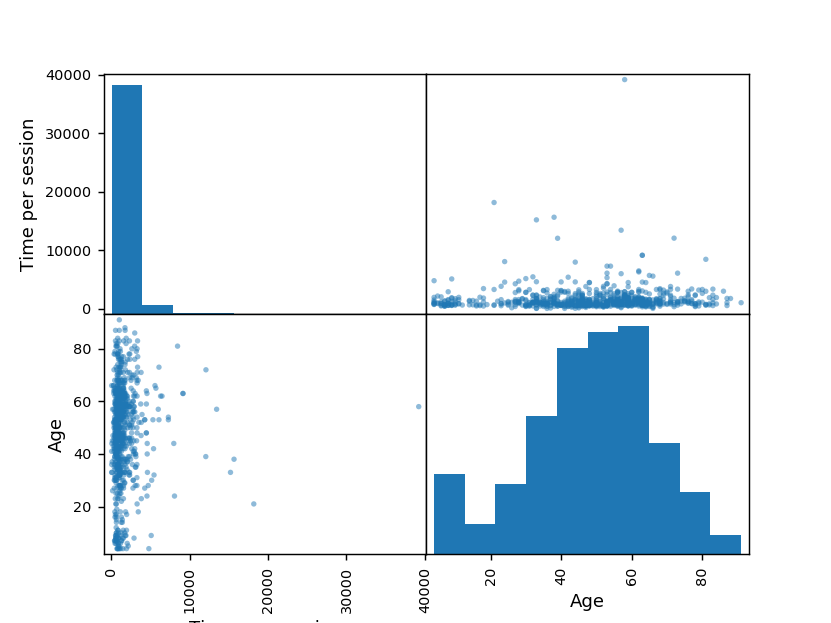

0.205626894324
['Age', 'Most freq channel', 'Personal Income', 'Weight', 'Standard of living index (Canceled)']
[(0.0010109678438579536, 'Weight'), (0.0018566709758092829, 'Sex'), (0.0042235928902065014, 'Any pet'), (0.0043163252541940133, 'Most freq genre'), (0.011410630945162677, 'Occupation Categories'), (0.011697394899615639, 'Average Household Income'), (0.015204718213347816, 'Household size'), (0.02612538886636457, 'Marital Status'), (0.034519926325327653, 'Education Level'), (0.035737793923731033, 'Grocery purch. decision maker'), (0.03937724266625587, 'Number of TV sets in HH'), (0.043278345455683827, 'Personal Income'), (0.044933536554165959, 'Age'), (0.052300537973387351, 'Children in household (10-14)'), (0.059349880258866825, 'Receiver Type'), (0.059971048444224455, 'Children in household (4-9)'), (0.10553766710397799, 'Most freq channel'), (0.12174428384301697, 'Standard of living index (Canceled)')]


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

df_final2 = df_final.copy()
del df_final2['No. of sessions'] # delete for this analysis

# set up features, target and train/test sets
X = df_final2.iloc[:,1:]
y = df_final2.iloc[:,0].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# fit random forest regressor, predict on test set and find R^2
clf_rf = RandomForestRegressor(random_state=0).fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
rf_score = r2_score(y_test, y_pred_rf)

%matplotlib notebook
# scatter matrix
pd.tools.plotting.scatter_matrix(df_final2[['Time per session', 'Age']])

# correlations
corrs=[]
for i in df_final2.columns[1:]:
    corrs.append((abs(df_final2['Time per session'].corr(df_final2[i].astype(int))),i))

# find top 5 features
top5=np.argsort(clf_rf.feature_importances_)[-5:][::-1]
features = df_final2.columns[1:]
top_features = []
for i in top5:
    top_features.append(features[i])

print(rf_score)
print(top_features)
print(sorted(corrs))